In [1]:
import numpy as np
import pandas as pd

import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

df_fullcleaned = pd.read_csv(r'C:\Users\Admin\Desktop\E_commerce_proj\data\output\data_full_cleaned.csv')

# 1. Lọc các cột để sử dụng cho kmean
# Mục đích: Phân khúc hành vi mua hàng
Dùng thuật toán KMeans để phân cụm khách hàng dựa trên đặc trưng RFM:

Recency (R): thời gian kể từ lần mua hàng gần nhất

Frequency (F): tần suất mua hàng

Monetary (M): tổng tiền đã chi tiêu




# PHẦN 1: Tính Toán RFM

In [2]:
df = df_fullcleaned.copy()
# tạo bản sao dữ liệu gốc


In [3]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Chuyển đổi cột 'Date' thành kiểu datetime

In [4]:
from datetime import timedelta
snapshot_date = df['Date'].max() + timedelta(days=1)
df['Recency'] = (snapshot_date - df['Date']).dt.days
#Tính Recency bằng số ngày kể từ lần mua cuối cùng đến "snapshot_date" (ngày mới nhất + 1 ngày)

In [5]:
freq_cols = ['NumGiftPurchases', ..., 'NumStorePurchases']
freq_cols = [c for c in freq_cols if c in df.columns]
df['Frequency'] = df[freq_cols].sum(axis=1)
#Tính Frequency bằng tổng số lần mua hàng từ nhiều loại hình (quà tặng, giảm giá, mua tại cửa hàng...)

In [6]:
df['Monetary'] = df['AmountSpent']
# Gán chi tiêu Monetary từ cột AmountSpent.

# PHẦN 2: TẠO MA TRẬN ĐẶC TRƯNG VÀ CHUẨN HÓA


In [7]:
rfm_features = ['Recency', 'Frequency', 'Monetary']
X = df[rfm_features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

#Trích các đặc trưng RFM thành ma trận X,
# sau đó chuẩn hóa bằng StandardScaler để dữ liệu có mean = 0, std = 1 giúp KMeans hoạt động hiệu quả hơn.

# PHẦN 3: Tìm số cụm tối ưu (k)

In [8]:
ks = range(2, 11)
sse, sil, ch, db = [], [], [], []

# Khởi tạo khoảng từ 2 đến 10 cụm và các list lưu chỉ số đánh giá:

# SSE: tổng bình phương khoảng cách nội cụm (Elbow method)

# Silhouette: mức độ tách biệt các cụm

# Calinski-Harabasz (CH): đánh giá độ đặc và phân tách cụm

# Davies-Bouldin (DB): giá trị thấp hơn là tốt

In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sse.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, labels))
    ch.append(calinski_harabasz_score(X_scaled, labels))
    db.append(davies_bouldin_score(X_scaled, labels))

#Chạy KMeans cho từng k, lưu lại các chỉ số đánh giá sau khi gán nhãn cho dữ liệu.

# PHẦN 4: Vẽ biểu đồ đánh giá để chọn k

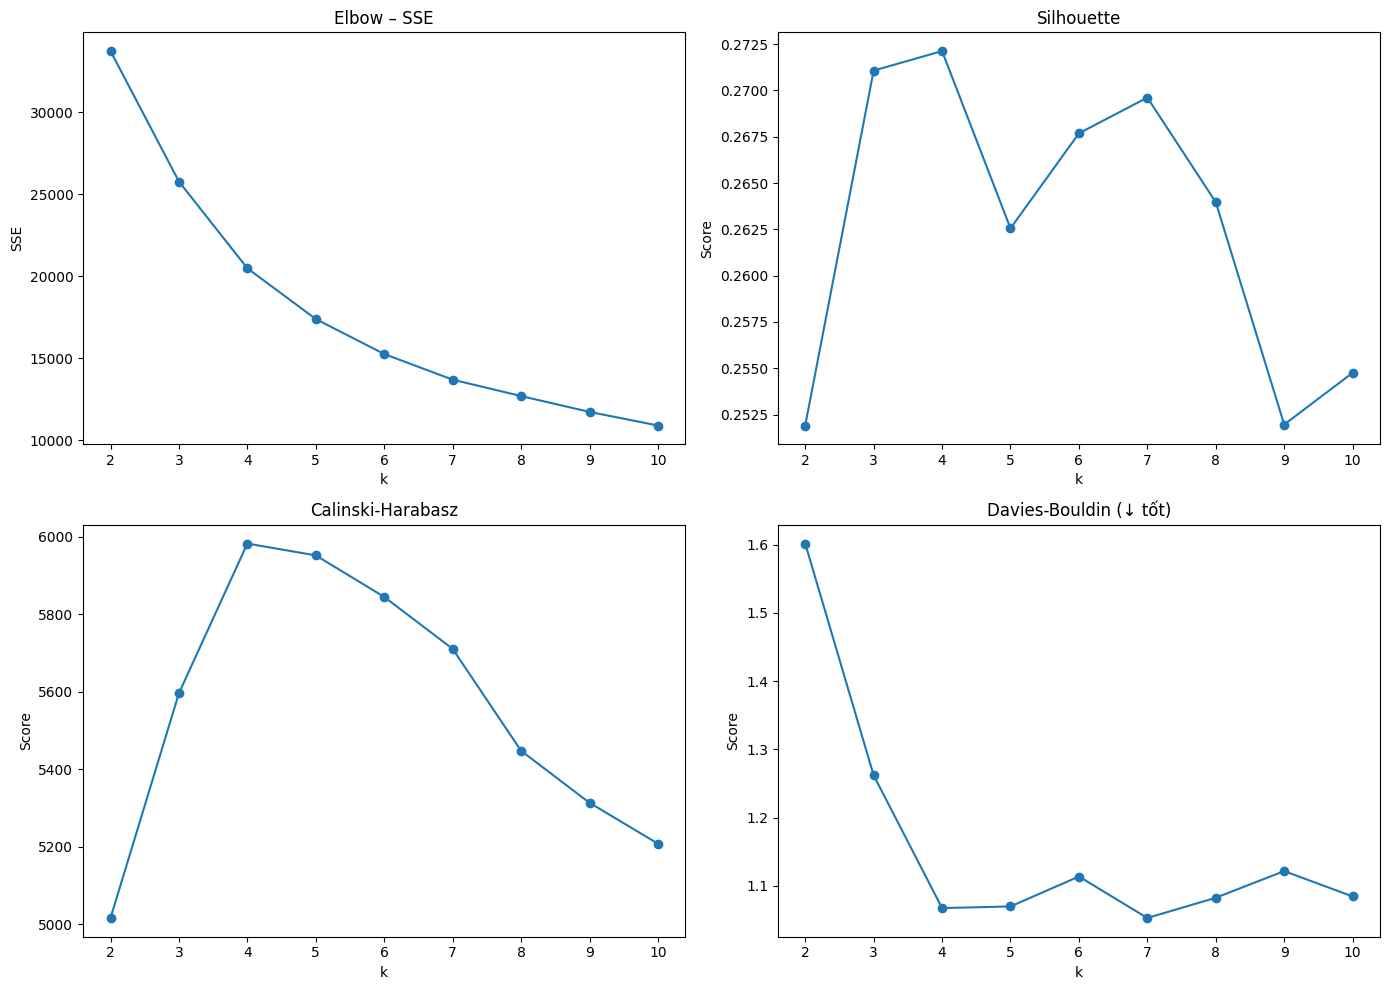

In [10]:
ig, axs = plt.subplots(2, 2, figsize=(14, 10))
# Elbow
axs[0,0].plot(ks, sse, marker='o'); axs[0,0].set_title('Elbow – SSE'); axs[0,0].set_xlabel('k'); axs[0,0].set_ylabel('SSE')
# Silhouette
axs[0,1].plot(ks, sil, marker='o'); axs[0,1].set_title('Silhouette'); axs[0,1].set_xlabel('k'); axs[0,1].set_ylabel('Score')
# Calinski–Harabasz
axs[1,0].plot(ks, ch, marker='o'); axs[1,0].set_title('Calinski-Harabasz'); axs[1,0].set_xlabel('k'); axs[1,0].set_ylabel('Score')
# Davies-Bouldin
axs[1,1].plot(ks, db, marker='o'); axs[1,1].set_title('Davies-Bouldin (↓ tốt)'); axs[1,1].set_xlabel('k'); axs[1,1].set_ylabel('Score')
plt.tight_layout(); plt.show()

# Phần 5: Chọn k tối ưu


In [11]:
k_opt = 4
# Chọn k=4 dựa trên các chỉ số đánh giá
# thường là điểm gãy Elbow, Silhouette cao nhất,
# CH cao & DB thấp

In [12]:
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


# Phần 6: Huẩn luyện với k tối ưu và gán nhãn


## NHÃN DÁN CHO CÁC CLUSTER
Segment:	Ý nghĩa hành vi thực tế,	Chiến lược, gợi ý

🏆 Champions	- Khách hàng có Recency thấp, Frequency cao, Monetary cao → Họ là khách hàng tốt nhất!	- Giữ chân bằng ưu đãi VIP, chăm sóc cá nhân, ưu tiên phản hồi nhanh

💚 Loyal	- Mua hàng thường xuyên, thường là Frequency cao, Monetary trung bình	- Tăng độ trung thành: tích điểm, quà tặng, khuyến mãi độc quyền

⚠️ At-Risk	- Recency cao, không quay lại gần đây, có thể từng chi tiêu cao	- Gửi email tái kích hoạt, khuyến mãi "chào quay lại", khảo sát lý do

😴 Sleepers	- Recency cao, Frequency & Monetary thấp → gần như không còn tương tác	- Có thể loại khỏi chiến dịch chính, hoặc thử chiến dịch gây tò mò nhẹ

In [ ]:
# ---------------------------------------------------------------
# . Gán nhãn hành vi khách hàng (Segment) theo điểm RFM
# ---------------------------------------------------------------

# Tính trung bình RFM theo cụm
grp = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Tính điểm tổng hợp: R thấp tốt, F và M cao tốt
grp['Score'] = (
    grp['Recency'].rank(ascending=True) + 
    grp['Frequency'].rank(ascending=False) +
    grp['Monetary'].rank(ascending=False)
).astype(int)

# Sắp xếp cụm theo điểm và gán nhãn
grp = grp.sort_values('Score', ascending=False)
default_labels = ['Champions', 'Loyal', 'At-Risk', 'Sleepers']
segment_map = {cluster: default_labels[i] for i, cluster in enumerate(grp.index)}
df['Segment'] = df['Cluster'].map(segment_map)

# ---------------------------------------------------------------
# x. Kiểm tra kết quả
# ---------------------------------------------------------------
print("=== Thống kê cụm khách hàng (theo RFM trung bình + điểm) ===")
print(grp[['Recency', 'Frequency', 'Monetary', 'Score']])


print("\n=== Phân bố khách hàng theo Segment ===")
print(df['Segment'].value_counts())


=== Thống kê cụm khách hàng (theo RFM trung bình + điểm) ===
          Recency  Frequency      Monetary  Score
Cluster                                          
0        7.231142   7.752039   7091.052611     11
3        2.400504  11.870931   6982.226365      8
1        7.036014  16.945843   7118.603936      6
2        5.380007  11.960609  19665.803701      5

=== Phân bố khách hàng theo Segment ===
Segment
Loyal        4362
Champions    3924
At-Risk      3693
Sleepers     3021
Name: count, dtype: int64


# Phần 7: Trực hóa

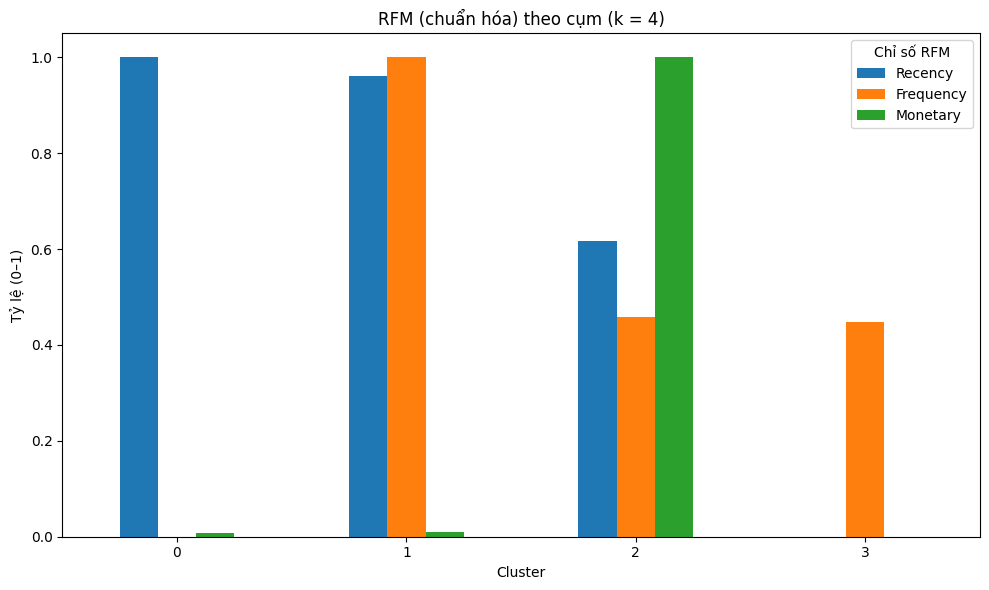

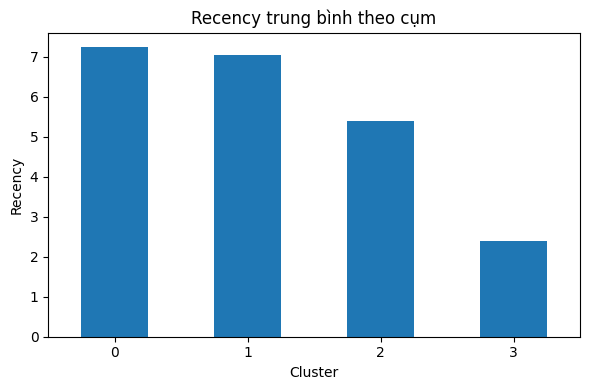

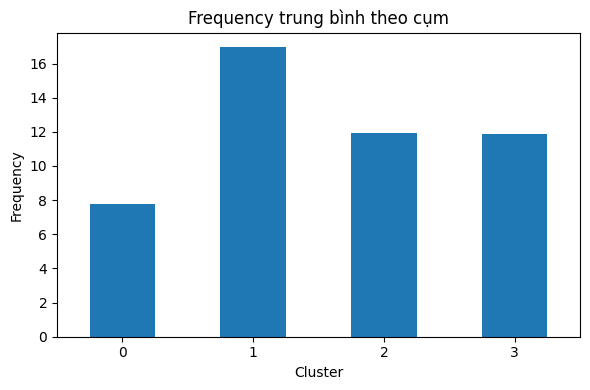

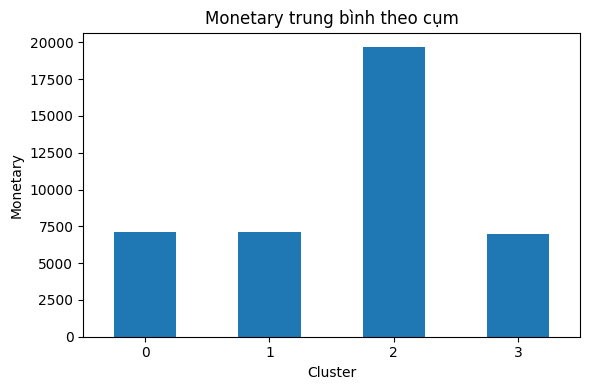

In [19]:
# ---------------------------------------------------------------
# BIỂU ĐỒ CỘT: RFM TRUNG BÌNH THEO CLUSTER (Phù hợp với Code 1)
# ---------------------------------------------------------------

# Tính trung bình RFM theo cụm
rfm_cols = ['Recency', 'Frequency', 'Monetary']
rfm_summary = (
    df.groupby('Cluster')[rfm_cols]
      .mean()
      .round(2)
      .sort_index()
)
rfm_normalized = rfm_summary.copy()
rfm_normalized = (rfm_normalized - rfm_normalized.min()) / (rfm_normalized.max() - rfm_normalized.min())

rfm_normalized.plot(kind='bar', figsize=(10, 6))
plt.title(f'RFM (chuẩn hóa) theo cụm (k = {k_opt})')
plt.xlabel('Cluster'); plt.ylabel('Tỷ lệ (0–1)')
plt.xticks(rotation=0); plt.legend(title='Chỉ số RFM')
plt.tight_layout(); plt.show()


for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_summary[col].plot(kind='bar', figsize=(6, 4), title=f'{col} trung bình theo cụm')
    plt.ylabel(col); plt.xlabel('Cluster'); plt.xticks(rotation=0)
    plt.tight_layout(); plt.show()




BIỂU ĐỒ PCA

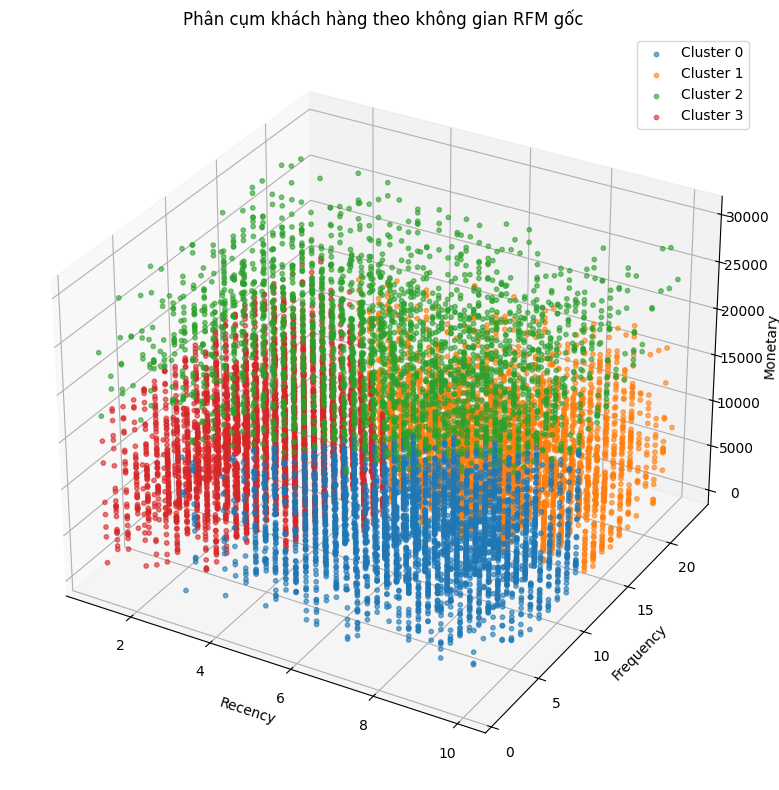

Cluster
3    4362
0    3924
1    3693
2    3021
Name: count, dtype: int64
Segment
Loyal        4362
Champions    3924
At-Risk      3693
Sleepers     3021
Name: count, dtype: int64


In [ ]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

colors = ['tab:blue','tab:orange','tab:green','tab:red']
for cl in sorted(df['Cluster'].unique()):
    sub = df[df['Cluster'] == cl]
    ax.scatter(sub['Recency'], sub['Frequency'], sub['Monetary'],
               c=colors[cl % len(colors)], label=f'Cluster {cl}', s=10, alpha=0.6)

ax.set_xlabel('Recency'); ax.set_ylabel('Frequency'); ax.set_zlabel('Monetary')
ax.set_title("Phân cụm khách hàng theo không gian RFM gốc")
ax.legend()
plt.tight_layout(); plt.show()


# Thống kê số lượng khách hàng theo cụm
print(df['Cluster'].value_counts())

# Nếu đã có nhãn Segment
print(df['Segment'].value_counts())


Phân Cụm Khách Hàng Theo Không Gian RFM Gốc

Biểu đồ dưới đây minh họa kết quả phân cụm khách hàng dựa trên ba đặc trưng RFM:

Recency (gần đây mua hàng)

Frequency (tần suất mua hàng)

Monetary (tổng chi tiêu)


Mỗi điểm trong không gian 3D đại diện cho một khách hàng, được tô màu theo cụm (cluster) mà mô hình KMeans phân loại được:

🟦 Cluster 0: Tập trung ở mức chi tiêu thấp & ít tần suất, có thể là nhóm khách hàng mới hoặc không tích cực.

🟧 Cluster 1: Chi tiêu trung bình, mua thường xuyên, tiềm năng trở thành khách hàng trung thành.

🟩 Cluster 2: Có chi tiêu cao nhất và mua nhiều lần, khả năng là nhóm khách VIP hoặc Champions.

🟥 Cluster 3: Mua gần đây nhưng tần suất thấp và chi tiêu thấp – có thể là khách mới cần nuôi dưỡng thêm.

## Heatmap

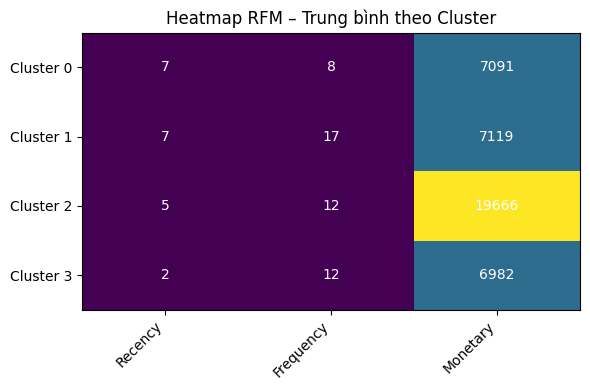

In [ ]:


import matplotlib.pyplot as plt

# Tính trung bình RFM theo cụm
rfm_cols = ['Recency', 'Frequency', 'Monetary']
rfm_means = (
    df.groupby('Cluster')[rfm_cols]
      .mean()
      .round(2)
      .sort_index()
)

# Chuẩn bị dữ liệu cho heatmap
data = rfm_means.values
clusters = rfm_means.index.astype(str)

# Vẽ heatmap
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(data, cmap='viridis', aspect='auto')

# Gán nhãn trục
ax.set_xticks(range(len(rfm_cols)))
ax.set_xticklabels(rfm_cols, rotation=45, ha='right')
ax.set_yticks(range(len(clusters)))
ax.set_yticklabels([f'Cluster {c}' for c in clusters])

# Ghi giá trị lên từng ô
for i in range(len(clusters)):
    for j in range(len(rfm_cols)):
        ax.text(j, i, f"{data[i, j]:.0f}", ha='center', va='center', color='w')

ax.set_title("Heatmap RFM – Trung bình theo Cluster")
fig.tight_layout()
plt.show()


Biểu đồ dưới đây minh họa trung bình giá trị RFM (Recency, Frequency, Monetary) của từng nhóm khách hàng sau khi phân cụm bằng thuật toán KMeans (k=4):

Trục dọc là các cụm khách hàng (Cluster 0–3)

Trục ngang là ba chỉ số hành vi:

Recency: số ngày kể từ lần mua cuối cùng (thấp hơn là tốt hơn)

Frequency: tần suất mua hàng (cao hơn là tốt hơn)

Monetary: tổng chi tiêu (cao hơn là tốt hơn)

Màu sắc thể hiện mức độ tương đối giữa các cụm – màu sáng hơn thể hiện giá trị cao hơn.

📌 Diễn giải cụm:
Cluster	Diễn giải tạm thời

Cluster 0	Recency = 7, Frequency = 8, Monetary = 7,091 → Khách hàng hoạt động vừa phải, chi tiêu trung bình

Cluster 1	Recency = 7, Frequency = 17, Monetary = 7,119 → Khách hàng thường xuyên mua, nhưng chi tiêu không cao

Cluster 2	Recency = 5, Frequency = 12, Monetary = 19,666 → Khách hàng có giá trị cao nhất, có thể là VIP / Champions

Cluster 3	Recency = 2, Frequency = 12, Monetary = 6,982 → Khách hàng mới hoặc tiềm năng, cần nuôi dưỡng

# Phần 8: Lưu cụm khách hàng ra một file để dễ kiểm tra


In [ ]:
# Xuất dữ liệu đã phân cụm ra file
df.to_csv('khach_hang_phan_cum.csv', index=False)
print("Đã lưu file 'khach_hang_phan_cum.csv'")


Đã lưu file 'khach_hang_phan_cum.csv'


# Từ đó có thể gợi ý chiến lược cho doanh nghiệp
Gợi ý chiến lược tiếp thị cho từng cụm khách hàng (Dựa trên RFM)
Giả sử kết quả trung bình các cụm như sau:

Cluster	Recency ↓	Frequency ↑	Monetary ↑	Nhóm mô tả
0	Thấp	Cao	Cao	Khách hàng trung thành
1	Cao	Thấp	Thấp	Khách hàng mất tích
2	Trung bình	Trung bình	Trung bình	Khách hàng tiềm năng
3	Thấp	Thấp	Cao	Mới mua giá trị cao

🔹 Chiến lược gợi ý theo từng nhóm:
Nhóm khách hàng	, đặc điểm chính,	Chiến lược tiếp thị
---------------------------------------
🟢 Cluster 0 – Trung thành	Mua thường xuyên, chi nhiều, ghé gần đây	- Ưu đãi thành viên VIP
- Giữ chân bằng tích điểm
- Gửi thư tri ân, ưu đãi sinh nhật

🔴 Cluster 1 – Mất tích	Lâu không mua, tần suất thấp, chi ít	- Gửi email khuyến mãi
- Giảm giá mạnh để tái kích hoạt
- Gửi khảo sát lý do rời đi

🟡 Cluster 2 – Tiềm năng	Hoạt động vừa phải, có thể trở thành khách trung thành	- Upsell/Cross-sell sản phẩm
- Chăm sóc qua newsletter
- Ưu đãi nhỏ khi quay lại sớm

🔵 Cluster 3 – Mới, chi cao	Mới mua gần đây, ít mua nhưng chi tiêu cao	- Chăm sóc sau mua
- Upsell sản phẩm tương tự
- Tạo trải nghiệm tốt để giữ chân